In [ ]:
'''Use most powerful devide available for optimization and efficiency'''
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🖥️ Using device: {device}")

🖥️ Using device: cuda


In [ ]:
'''Install Dependencies'''
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379370 sha256=42d0346e34313723d74590888e07cfe2b507bb231f27149db61cbf84ef3cb0d5
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [ ]:
'''Import requried Libraries'''
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import collections
import matplotlib.pyplot as plt
import imageio
import os
from google.colab import drive

In [ ]:
'''Mount Drive for File Saving'''
drive.mount('/content/drive')
output_dir = "/content/drive/MyDrive/lunar_lander_output"
os.makedirs(output_dir, exist_ok=True)
video_folder = "./dqn_videos"
os.makedirs(video_folder, exist_ok=True)

Mounted at /content/drive


In [ ]:
# --- DQN Model ---
class QNetwork(nn.Module):
  '''Naural Network for Q-Learning.
   With 3 training layers abd 2 activation layers.'''
  def __init__(self, state_size, action_size, hidden_size=64):
    super(QNetwork, self).__init__()
    self.model = nn.Sequential(
    nn.Linear(state_size, hidden_size), #Trainable
    nn.ReLU(),                          #Activation
    nn.Linear(hidden_size, hidden_size),#Trainable
    nn.ReLU(),                          #Activation
    nn.Linear(hidden_size, action_size) #Trainable
    )

  def forward(self, x): #Pass X through the Network
    return self.model(x)

In [ ]:
# --- Replay Buffer ---
class ReplayBuffer:
  '''Replay Memory Object for Storing Experience'''
  def __init__(self, capacity=100_000):
    self.buffer = collections.deque(maxlen=capacity)

  def push(self, state, action, reward, next_state, done): #Add to the buffer
    self.buffer.append((state, action, reward, next_state, done))

  def sample(self, batch_size): #Take random sample from the buffer
    batch = random.sample(self.buffer, batch_size)
    state, action, reward, next_state, done = map(np.array, zip(*batch))
    return state, action, reward, next_state, done

  def __len__(self): #Return length of experience
    return len(self.buffer)

In [ ]:
# --- Reward shaping ---
def shaped_reward(state, reward):
  '''add extra rewards for desirable actions'''
  if abs(state[1]) < 0.5: #Centerd vertically
    reward += 0.3
  if abs(state[4]) < 0.1: #Upright
    reward += 0.2
  return reward

In [ ]:
# --- Hyperparameters ---
'''Adjust parameters for different performances'''
seed = 42                     #Reproduction
num_episodes = 1000           #Defined in the task
batch_size = 256              #Reduce varaince in gradient estimates (increase stability)
min_buffer_size = 2000        #Stack memory before we begin sampling from the past
buffer_capacity = 100000      #Add a limit to memory for efficiency
target_update_steps = 250     #Frequency of target network updates
learning_rate = 1e-3          #Strength of pulling Q-values towards target
gamma = 0.98                  #discount factor
epsilon_start = 1.0
epsilon_min = 0.05
epsilon_decay = 0.995
hidden_size = 64
moving_average_window = 50

In [ ]:
# --- Setup ---
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

env = gym.make("LunarLander-v3", render_mode="rgb_array")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

q_network = QNetwork(state_size, action_size, hidden_size).to(device)
target_network = QNetwork(state_size, action_size, hidden_size).to(device)
target_network.load_state_dict(q_network.state_dict())

optimizer = optim.Adam(q_network.parameters(), lr=learning_rate)
replay_buffer = ReplayBuffer(capacity=buffer_capacity)

rewards = []
losses = []
steps_done = 0
update_counter = 0

In [ ]:
# --- Training Loop ---
for episode in range(num_episodes):
    state, _ = env.reset()
    total_reward = 0
    done = False

    while not done:
        epsilon = max(epsilon_min, epsilon_start * (epsilon_decay ** (steps_done)))
        steps_done += 1

        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                action = q_network(state_tensor).max(1)[1].item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        shaped = shaped_reward(state, reward)
        replay_buffer.push(state, action, shaped, next_state, done)

        state = next_state
        total_reward += reward

        if len(replay_buffer) >= min_buffer_size:
            states, actions, rewards_batch, next_states, dones = replay_buffer.sample(batch_size)

            states = torch.FloatTensor(states).to(device)
            actions = torch.LongTensor(actions).unsqueeze(1).to(device)
            rewards_batch = torch.FloatTensor(rewards_batch).to(device)
            next_states = torch.FloatTensor(next_states).to(device)
            dones = torch.FloatTensor(dones).to(device)

            q_values = q_network(states).gather(1, actions).squeeze(1)
            next_actions = q_network(next_states).max(1)[1].unsqueeze(1)
            next_q_values = target_network(next_states).gather(1, next_actions).squeeze(1)
            expected_q_values = rewards_batch + gamma * next_q_values * (1 - dones)

            loss = nn.MSELoss()(q_values, expected_q_values)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

            update_counter += 1
            if update_counter % target_update_steps == 0:
                target_network.load_state_dict(q_network.state_dict())

    rewards.append(total_reward)

    if episode % 100 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.2f}")

Episode 0, Total Reward: -77.19, Epsilon: 0.05
Episode 100, Total Reward: 17.17, Epsilon: 0.05
Episode 200, Total Reward: -36.52, Epsilon: 0.05
Episode 300, Total Reward: 170.73, Epsilon: 0.05
Episode 400, Total Reward: 265.02, Epsilon: 0.05
Episode 500, Total Reward: 283.75, Epsilon: 0.05
Episode 600, Total Reward: 273.56, Epsilon: 0.05
Episode 700, Total Reward: 251.77, Epsilon: 0.05
Episode 800, Total Reward: 98.81, Epsilon: 0.05
Episode 900, Total Reward: 253.38, Epsilon: 0.05


In [ ]:
# --- Save model ---
torch.save(q_network.state_dict(), os.path.join(output_dir, "dqn_lander_agent.pth"))

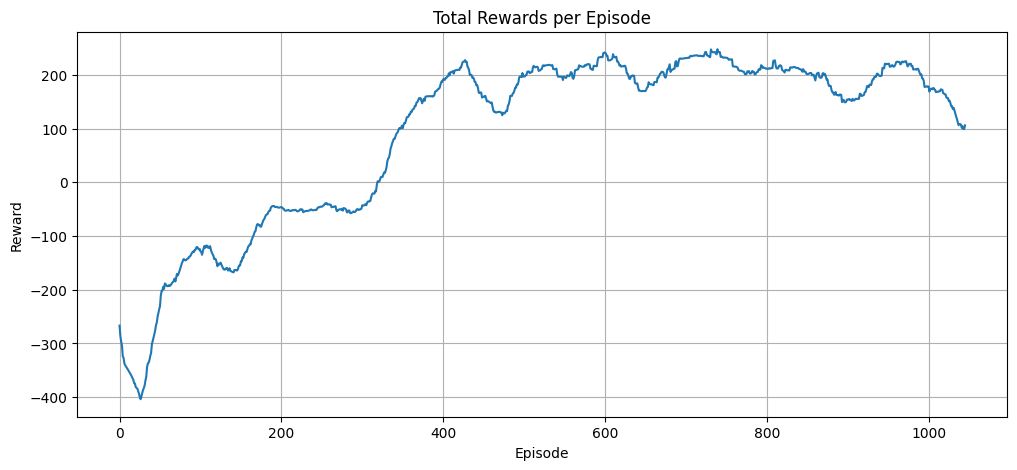

In [ ]:
# --- Plot results ---
def smooth(y, window=50):
    box = np.ones(window)/window
    return np.convolve(y, box, mode='same')

plt.figure(figsize=(12,5))
plt.title("Total Rewards per Episode")
plt.plot(smooth(rewards, moving_average_window))
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid()
plt.savefig(os.path.join(output_dir, "reward_curve.png"))
plt.show()

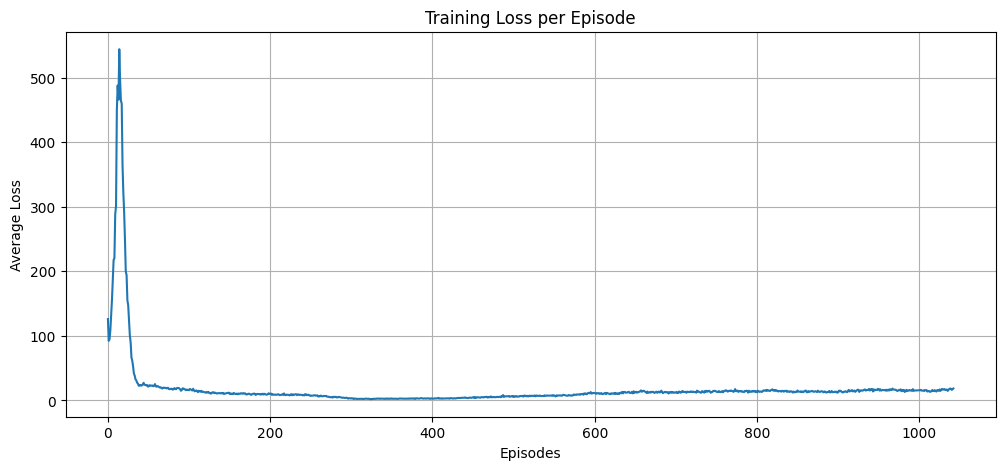

In [ ]:
import numpy as np

steps_per_episode = 400 #approximately
num_episodes = len(losses) // steps_per_episode

# Compute average loss per episode
losses_trimmed = losses[:num_episodes * steps_per_episode]
losses_per_episode = np.mean(
    np.array(losses_trimmed).reshape(num_episodes, steps_per_episode), axis=1
)

# Plot
plt.figure(figsize=(12, 5))
plt.title("Training Loss per Episode")
plt.plot(losses_per_episode)
plt.xlabel("Episodes")
plt.ylabel("Average Loss")
plt.grid()
plt.savefig(os.path.join(output_dir, "loss_curve_per_episode.png"))
plt.show()


In [ ]:
from PIL import Image, ImageDraw, ImageFont
import torch
import imageio
import os
import numpy as np

frames = []
state, _ = env.reset()
done = False
cumulative_reward = 0

while not done:
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    with torch.no_grad():
        action = q_network(state_tensor).max(1)[1].item()
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    cumulative_reward += reward

    # Render the frame
    frame = env.render()
    frame_image = Image.fromarray(frame)
    draw = ImageDraw.Draw(frame_image)

    # Font for text
    try:
        font = ImageFont.truetype("arial.ttf", 16)
    except:
        font = ImageFont.load_default()

    # Extract state values
    x_pos, y_pos, x_vel, y_vel, angle, ang_vel, left_leg, right_leg = state

    # Build metric strings
    metrics = [
        f"X Pos:     {x_pos:.2f}",
        f"Y Pos:     {y_pos:.2f}",
        f"X Vel:     {x_vel:.2f}",
        f"Y Vel:     {y_vel:.2f}",
        f"Angle:     {angle:.2f}",
        f"Ang Vel:   {ang_vel:.2f}",
        f"Left Leg:  {'Yes' if left_leg > 0.0 else 'No'}",
        f"Right Leg: {'Yes' if right_leg > 0.0 else 'No'}",
        f"Action:    {action}",
        f"Score:     {cumulative_reward:.1f}"
    ]

    # Draw each metric line
    for i, line in enumerate(metrics):
        draw.text((10, 10 + i * 18), line, fill="white", font=font)

    frames.append(np.array(frame_image))
    state = next_state

env.close()

# Save the GIF — fit entire episode in 5 seconds
gif_duration_ms = 5000
frame_count = len(frames)
frame_duration = gif_duration_ms / frame_count

os.makedirs(video_folder, exist_ok=True)
imageio.mimsave(os.path.join(video_folder, "lunar_lander_agent.gif"), frames, duration=frame_duration / 1000)

print("GIF saved in ./dqn_videos folder!")


GIF saved in ./dqn_videos folder!
